# Probabilistic Record Matching Demo

This notebook demonstrates the probabilistic record matching system. We will walk through the code step-by-step, explaining each function as we go and inspecting the results.

In [69]:
import pandas as pd
import numpy as np
import random
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from itertools import combinations
from data_generator import generate_data
import matplotlib.pyplot as plt

pd.set_option('display.width', 1000)

## 1. Generate Data
We generate a synthetic dataset with 80 unique records and 20 perturbed duplicates.
We also introduce **missing data** (None) in some fields to simulate real-world imperfections.

In [71]:
df = generate_data()
fields = ['name', 'address', 'city', 'date_of_birth']
print(f"Generated {len(df)} records.")
print("\nFirst 5 records (note potential None values):")
display(df[fields].head())

Generated 240 records.

First 5 records (note potential None values):


,name,address,city,date_of_birth
0,Daniel Doyle,"600 Jeffery Parkways, New Jamesside, MT 29394",None,2013-02-26
1,Christopher Bernard,"1559 Roman Stream, Herrerafurt, CO 72858",Mariastad,1988-06-17
2,Patricia Galloway,"4752 Kelly Skyway, Jacquelineland, PA 83728",None,1932-02-14
3,Melissa Robinson,None,Thomasberg,1943-06-13
4,Jessica Silva,None,Riceside,1911-06-12


## 2. Compute Similarities
The first step is to convert the text data in each field into a numerical representation (embedding) using a language model. We then calculate the cosine similarity between all pairs of records for each field.

We use `all-MiniLM-L6-v2`, a lightweight and efficient model.

In [72]:
def compute_similarities(df, fields, model_name='all-MiniLM-L6-v2'):
    """
    Computes cosine similarity matrices for each field independently.

    Reasoning:
    ----------
    We use a pre-trained sentence transformer model (`all-MiniLM-L6-v2`) to generate dense vector
    embeddings for each text field. This model is chosen for its efficiency and good performance
    on semantic similarity tasks.

    Missing Data Handling:
    ----------------------
    If a field is missing (None/NaN) for either record in a pair, we set the similarity score to 0.
    
    Why?
    - **Avoid False Positives**: If we simply filled missing values with an empty string, two records
      with missing addresses would have a similarity of 1.0 (perfect match of empty strings).
      This would falsely boost the match probability.
    - **Conservative Approach**: By setting similarity to 0, we treat missing data as providing
      *no evidence* of a match. The model must rely on other present fields (like Name) to
      make the decision.
    """
    print("Computing embeddings and similarities...")
    model = SentenceTransformer(model_name)
    sim_matrices = {}
    
    for f in fields:
        # 1. Identify missing values
        missing_mask = df[f].isna() | (df[f] == '')
        
        # 2. Encode (fill NaNs temporarily for encoding)
        embeddings = model.encode(df[f].fillna('').astype(str).tolist())
        
        # 3. Compute Cosine Similarity
        sim_matrix = cosine_similarity(embeddings)
        
        # 4. Apply Mask: Set similarity to 0 if either record has missing data
        # We set rows and columns corresponding to missing data to 0
        # Note: This sets (missing, missing) to 0, and (missing, present) to 0.
        sim_matrix[missing_mask, :] = 0
        sim_matrix[:, missing_mask] = 0
        
        sim_matrices[f] = sim_matrix
        
    return sim_matrices

sim_matrices = compute_similarities(df, fields)

# Inspect results
print(f"\nComputed similarity matrices for fields: {list(sim_matrices.keys())}")
print(f"Shape of 'name' similarity matrix: {sim_matrices['name'].shape}")

# Show a sample similarity score
print(f"Similarity between record 0 and 1 for 'name': {sim_matrices['name'][0][1]:.4f}")

Computing embeddings and similarities...

Computed similarity matrices for fields: ['name', 'address', 'city', 'date_of_birth']
Shape of 'name' similarity matrix: (240, 240)
Similarity between record 0 and 1 for 'name': 0.3562


## 3. Train Model
Instead of manually tuning weights for each field (e.g., deciding that Name is 2x more important than Date of Birth), we use Logistic Regression to learn these weights from the data.

We create a training set by:
1.  Finding all **positive pairs** (records that are actually the same person).
2.  Sampling **negative pairs** (records that are different people).
3.  Using the similarity scores of the fields as features to predict whether a pair is a match.

In [73]:
def train_model(df, fields, sim_matrices):
    """
    Trains a Logistic Regression model to classify pairs of records as matches or non-matches.

    Reasoning:
    ----------
    We use Logistic Regression because it provides a probabilistic output and is highly interpretable.
    The coefficients (weights) learned by the model tell us exactly how important each field is for
    determining a match.

    Impact of Missing Data:
    -----------------------
    Since we set the similarity of missing fields to 0, the model sees these as "dissimilar".
    However, because we train on many examples, the model learns to weight the *present* fields appropriately.
    If 'Address' is frequently missing but 'Name' is always present and accurate, the model might assign
    a higher weight to 'Name' and a slightly lower weight to 'Address' (or keep it high, but relying on
    it only when present).
    """
    print("Training model...")
    pos_pairs = [(i, j) for i, j in combinations(range(len(df)), 2) 
                 if df.iloc[i]['original_id'] == df.iloc[j]['original_id']]
    
    neg_pairs = set()
    while len(neg_pairs) < len(pos_pairs) * 5:
        i, j = sorted(random.sample(range(len(df)), 2))
        if df.iloc[i]['original_id'] != df.iloc[j]['original_id']:
            neg_pairs.add((i, j))
            
    X, y = [], []
    for pairs, label in [(pos_pairs, 1), (list(neg_pairs), 0)]:
        for i, j in pairs:
            X.append([sim_matrices[f][i][j] for f in fields])
            y.append(label)
            
    clf = LogisticRegression(class_weight='balanced').fit(X, y)
    return clf

clf = train_model(df, fields, sim_matrices)

# Inspect learned weights
print("\nLearned Feature Weights (Importance):")
weights = dict(zip(fields, clf.coef_[0]))
display(pd.DataFrame(list(weights.items()), columns=['Field', 'Weight']).sort_values('Weight', ascending=False))

Training model...

Learned Feature Weights (Importance):


,Field,Weight
0,name,4.998122
1,address,2.694338
2,city,2.430271
3,date_of_birth,0.775154


## 4. Predict Matches
Now that we have a trained model, we can use it to score every pair of records in the dataset. If the model predicts a match probability greater than 70%, we consider it a match.

**Note**: We filter out pairs where the records are identical in all fields, as these are trivial matches.

In [74]:
def predict_matches(df, fields, sim_matrices, clf, threshold=0.7):
    """
    Predicts match probabilities for all pairs of records in the dataset.

    Reasoning:
    ----------
    We apply the trained classifier to feature vectors derived from the similarity matrices.
    This combines the individual field similarities into a single probability score.

    Decisions & Assumptions:
    ------------------------
    - **Thresholding**: We use a default threshold of 0.7. Pairs with a probability > 0.7 are
      considered matches. This higher threshold reduces false positives at the cost of potentially
      missing some true matches (lower recall).
    - **Filtering Trivial Matches**: We explicitly skip pairs where all fields are identical.
    """
    print("Predicting matches...")
    matches = []
    for i, j in combinations(range(len(df)), 2):
        # Skip if the records are identical in the fields we care about
        if all(df.iloc[i][f] == df.iloc[j][f] for f in fields):
            continue

        features = [sim_matrices[f][i][j] for f in fields]
        prob = clf.predict_proba([features])[0][1]
        if prob > threshold:
            matches.append({
                'index_a': i, 'index_b': j,
                'record_a': df.iloc[i]['name'], 'record_b': df.iloc[j]['name'], 
                'score': prob, 'is_match': df.iloc[i]['original_id'] == df.iloc[j]['original_id']
            })
    return pd.DataFrame(matches).sort_values('score', ascending=False)

matches = predict_matches(df, fields, sim_matrices, clf)

# Filter out exact name matches to show only fuzzy matches
fuzzy_matches = matches[matches['record_a'] != matches['record_b']]

print(f"\nFound {len(matches)} total matches.")
print(f"Found {len(fuzzy_matches)} fuzzy matches (excluding exact name matches).")
print("\nTop 10 Fuzzy Matches:")
display(fuzzy_matches.head(10))

Predicting matches...

Found 21 total matches.
Found 8 fuzzy matches (excluding exact name matches).

Top 10 Fuzzy Matches:


,index_a,index_b,record_a,record_b,score,is_match
4,21,200,Pamela James,Pamela aJmes,0.973795,True
13,98,230,Ronald Miller,Rronald Miller,0.950202,True
3,18,216,Mary Campbell,Mary CampVell,0.942377,True
10,71,221,Michael Graves,Michael Grvaes,0.901813,True
7,40,213,Charles Schmidt,Charles Schimdt,0.891076,True
2,13,210,Anna Henderson,Apna Henderson,0.889287,True
19,207,210,Anna Henderson,Apna Henderson,0.889287,True
15,144,188,Lisa Davis,Danielle Davis,0.758868,False


## 5. Fields Used for Comparison & Example
Finally, we list the fields that were used and show a side-by-side comparison of a detected fuzzy match.

In [75]:
print("Fields used for matching:")
for f in fields:
    print(f"- {f}")

if len(fuzzy_matches) > 0:
    print("\nExample Fuzzy Match Comparison (Top Match):")
    # Get indices of the top fuzzy match
    top_match = fuzzy_matches.iloc[0]
    idx_a = int(top_match['index_a'])
    idx_b = int(top_match['index_b'])
    
    # Extract data for these two records
    rec_a = df.iloc[idx_a][fields]
    rec_b = df.iloc[idx_b][fields]
    
    # Create a comparison table
    comparison = pd.DataFrame({'Record A': rec_a, 'Record B': rec_b})
    display(comparison)
else:
    print("\nNo fuzzy matches found to display comparison.")

Fields used for matching:
- name
- address
- city
- date_of_birth

Example Fuzzy Match Comparison (Top Match):


,Record A,Record B
name,Pamela James,Pamela aJmes
address,"6688 Tracy Groves Suite 706, Elizabethfurt, VA...","6688 Tracy Groves Suite 706, Elizabethfurt, VA..."
city,Calhounside,Calhounside
date_of_birth,1913-07-21,1913-07-21


## 6. Accuracy & Error Analysis
We evaluate the model's performance by comparing predictions against ground truth labels.

In [76]:
if not matches.empty:
    # Calculate accuracy metrics
    true_positives = len(matches[matches['is_match'] == True])
    false_positives = len(matches[matches['is_match'] == False])
    
    # Count actual positives in the dataset
    actual_positives = len([(i, j) for i, j in combinations(range(len(df)), 2) 
                            if df.iloc[i]['original_id'] == df.iloc[j]['original_id']
                            and not all(df.iloc[i][f] == df.iloc[j][f] for f in fields)])
    
    false_negatives = actual_positives - true_positives
    
    precision = true_positives / len(matches) if len(matches) > 0 else 0
    recall = true_positives / actual_positives if actual_positives > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print("=" * 50)
    print("MATCHING PERFORMANCE METRICS")
    print("=" * 50)
    print(f"\nTrue Positives (Correct Matches): {true_positives}")
    print(f"False Positives (Incorrect Matches): {false_positives}")
    print(f"False Negatives (Missed Matches): {false_negatives}")
    print(f"\nPrecision: {precision:.2%} (of predicted matches, how many are correct)")
    print(f"Recall: {recall:.2%} (of actual matches, how many did we find)")
    print(f"F1 Score: {f1_score:.2%} (harmonic mean of precision and recall)")
    
    # Show examples of errors if they exist
    if false_positives > 0:
        print("\n" + "=" * 50)
        print("FALSE POSITIVES (Incorrectly Predicted as Matches)")
        print("=" * 50)
        false_pos = matches[matches['is_match'] == False].head(5)
        display(false_pos[['record_a', 'record_b', 'score']])
    
    if false_negatives > 0:
        print("\n" + "=" * 50)
        print(f"FALSE NEGATIVES: {false_negatives} actual matches were missed")
        print("These are pairs with the same original_id but score < 0.7")
        print("=" * 50)
else:
    print("No matches found to evaluate.")

MATCHING PERFORMANCE METRICS

True Positives (Correct Matches): 20
False Positives (Incorrect Matches): 1
False Negatives (Missed Matches): 3

Precision: 95.24% (of predicted matches, how many are correct)
Recall: 86.96% (of actual matches, how many did we find)
F1 Score: 90.91% (harmonic mean of precision and recall)

FALSE POSITIVES (Incorrectly Predicted as Matches)


,record_a,record_b,score
15,Lisa Davis,Danielle Davis,0.758868



FALSE NEGATIVES: 3 actual matches were missed
These are pairs with the same original_id but score < 0.7


## 7. Match Probability Statistics
We analyze the distribution of match probabilities to understand the model's confidence.

Match Probability Statistics:
Min: 0.7589
Max: 0.9907
Mean: 0.9094
Median: 0.9053
Std Dev: 0.0730


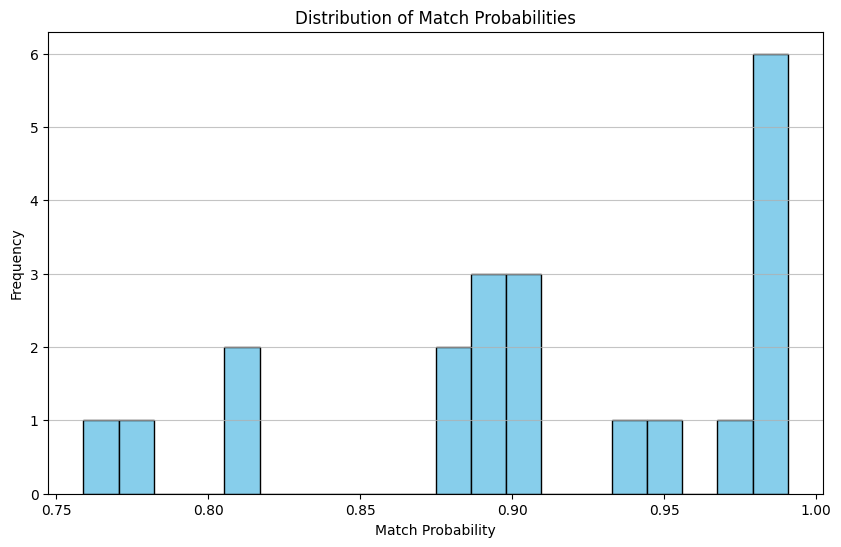

In [77]:
if not matches.empty:
    scores = matches['score']
    print("Match Probability Statistics:")
    print(f"Min: {scores.min():.4f}")
    print(f"Max: {scores.max():.4f}")
    print(f"Mean: {scores.mean():.4f}")
    print(f"Median: {scores.median():.4f}")
    print(f"Std Dev: {scores.std():.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(scores, bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Match Probabilities')
    plt.xlabel('Match Probability')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()
else:
    print("No matches found to analyze.")